In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.algorithms.optimizers import COBYLA
from IPython.display import clear_output
plt.style.use("default")

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


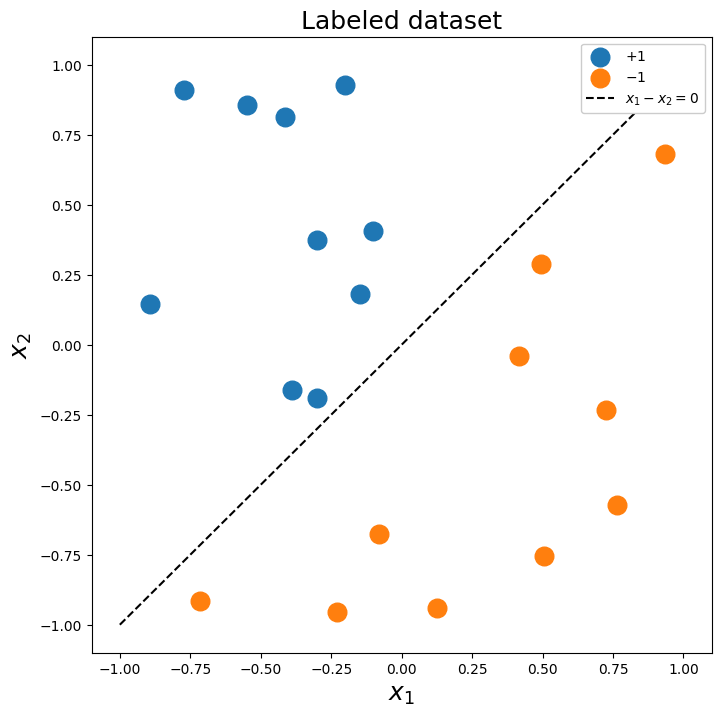

In [2]:
np.random.seed(32488)
#generating data set
N_samples = 20
X = np.random.uniform(-1, 1, (N_samples, 2))
plus = X[:, 0] < X[:, 1] # data points labeled +1 if x_1 < x_2 and -1 otherwise
xp = X[plus]
xm = X[~plus]
labels = np.ones(N_samples) #one hot encoded labels (10 for +1 and 01 for -1)
labels[~plus] *= -1
labels01 = (labels + 1) / 2
labels_one_hot = np.zeros((N_samples, 2))
labels_one_hot[plus, 0] = 1
labels_one_hot[~plus, 1] = 1
fig1, ax1 = plt.subplots(1, 1, figsize = (8, 8))
ax1.scatter(xp[:, 0], xp[:, 1], label = "$+1$", s = 180)
ax1.scatter(xm[:, 0], xm[:, 1], label = "$-1$", s = 180)
ax1.plot([-1, 1], [-1, 1], ls = "--", c = "black", label = "$x_1 - x_2 = 0$")
ax1.set_xlabel("$x_1$", size = 18)
ax1.set_ylabel("$x_2$", size = 18)
ax1.set_title("Labeled dataset", size = 18)
ax1.legend(loc = "upper right", framealpha = 1)

## Estimator Quantum Neural Network

The neural network is defined by a quantum circuit parameterized by the input and network weights and an observable.

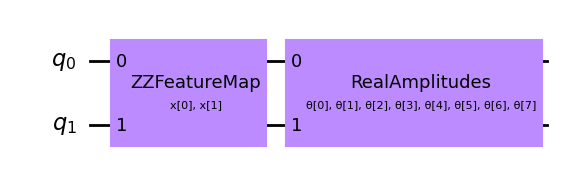

In [3]:
qc = QuantumCircuit(2)
feature_map = ZZFeatureMap(2, reps = 1)
ansatz = RealAmplitudes(2, reps = 3)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)
qc.draw(output="mpl")

The feature map $U_F$ maps the input data to quantum state in the feature space $x \in R^d \rightarrow |\phi(x) \rangle = U_F(x) |0\rangle$.

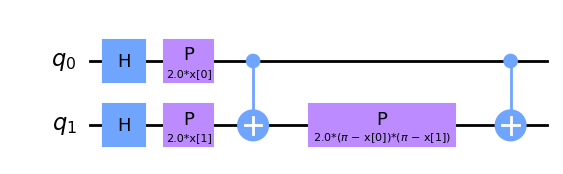

In [4]:
feature_map.decompose().draw("mpl")

Ansatz circuit $U_A$ parameterized by the weights of the network. The output of the network is the expectation value of an observable $\langle\psi(x)| A | \psi(x) \rangle$, where $|\psi(x)\rangle = U_A(w_1, w_2, \ldots, w_n) |\phi(x)\rangle$.

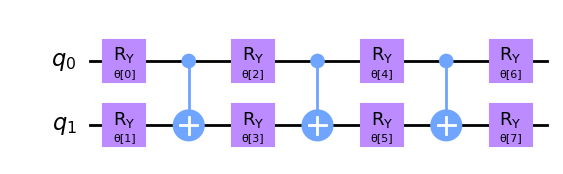

In [5]:
ansatz.decompose().draw("mpl")

In [6]:
# creating the estimator network
# the observable defaults to Z Z
qnn_estimator = EstimatorQNN(circuit=qc, input_params=feature_map.parameters, weight_params=ansatz.parameters)

In [7]:
#forward propagation using random weights
qnn_estimator.forward(X[0], np.random.uniform(0, 2 * np.pi, len(ansatz.parameters)))

Traceback (most recent call last):
  Input In [7] in <cell line: 2>
    qnn_estimator.forward(X[0], np.random.uniform(0, 2 * np.pi, len(ansatz.parameters)))
NameError: name 'X' is not defined

Use %tb to get the full traceback.


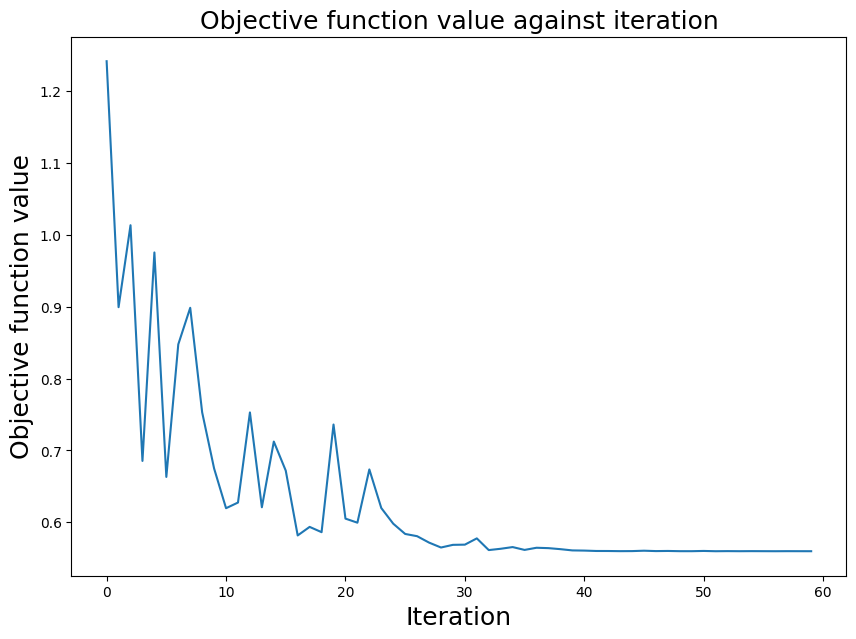

In [8]:
#training on the data set
objective_func_vals = []
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    fig, ax = plt.subplots(1, 1, figsize = (10, 7))
    plt.title("Objective function value against iteration", size = 18)
    plt.xlabel("Iteration", size = 18)
    plt.ylabel("Objective function value", size = 18)
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()
estimator_classifier = NeuralNetworkClassifier(qnn_estimator, optimizer=COBYLA(maxiter=60), callback=callback_graph, initial_point = np.random.uniform(-np.pi, np.pi, len(ansatz.parameters)))
estimator_classifier.fit(X, labels)

In [9]:
estimator_classifier.score(X, labels)

0.9

In [1]:
y_predicted = estimator_classifier.predict(X).ravel()
miss_classifed = (y_predicted != labels)
fig2, ax2 = plt.subplots(1, 1, figsize = (8, 8))
ax2.scatter(xp[:, 0], xp[:, 1], label = "$+1$", s = 180, alpha = 0.75, zorder = 0)
ax2.scatter(xm[:, 0], xm[:, 1], label = "$-1$", s = 180, alpha = 0.75, zorder = 0)
ax2.scatter(X[miss_classifed][:, 0], X[miss_classifed][:, 1], label = "Miss classified", c  = "red", marker = "x", alpha = 1, zorder = 20, s = 100)
ax2.plot([-1, 1], [-1, 1], ls = "--", c = "black", label = "$x_1 - x_2 = 0$")
ax2.set_xlabel("$x_1$", size = 18)
ax2.set_ylabel("$x_2$", size = 18)
ax2.set_title("Predictions", size = 18)
grid_L = 50
xx = np.outer(np.ones(grid_L), np.linspace(-1, 1, grid_L))
yy = np.outer(np.linspace(-1, 1, grid_L), np.ones(grid_L))
zz = estimator_classifier.predict(np.vstack([xx.ravel(), yy.ravel()]).T).ravel().reshape(grid_L, grid_L)
ax2.pcolormesh(xx, yy, zz, cmap = "gray" ,alpha = 0.2, zorder = -10)
ax2.legend(loc = "upper right", framealpha = 1)

Traceback (most recent call last):
  Input In [1] in <cell line: 1>
    y_predicted = estimator_classifier.predict(X).ravel()
NameError: name 'estimator_classifier' is not defined

Use %tb to get the full traceback.


## Sampler Quantum Neural Network

In [11]:
def parity(x):
    return "{:b}".format(x).count("1") % 2

output_shape = 2
sampler_qnn = SamplerQNN(circuit=qc, input_params=feature_map.parameters, weight_params=ansatz.parameters,
                         interpret=parity, output_shape=output_shape)

#classifier constructor
sampler_classifier = NeuralNetworkClassifier(neural_network=sampler_qnn, optimizer=COBYLA(maxiter=50), callback=callback_graph)

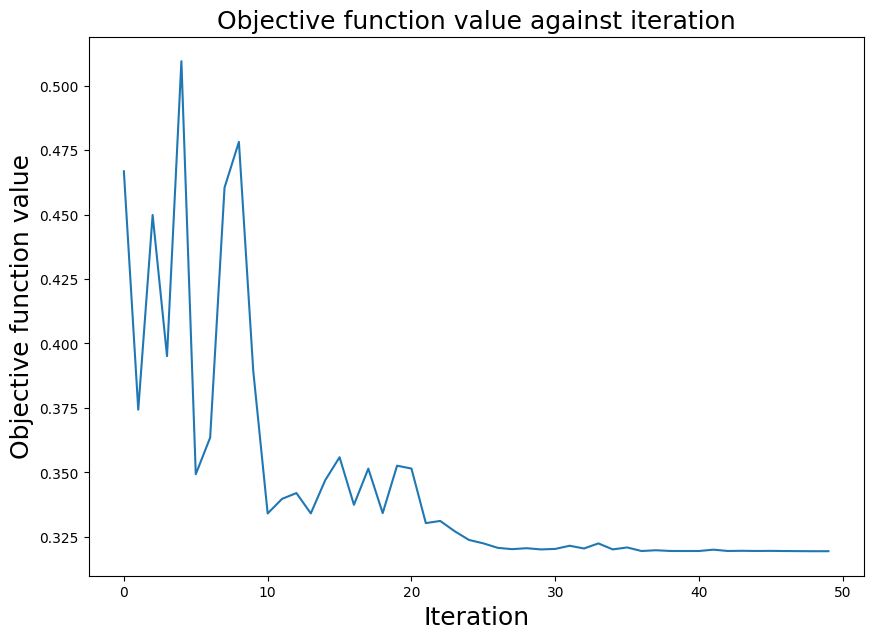

In [12]:
# training
objective_func_vals = []
sampler_classifier.fit(X, labels01)

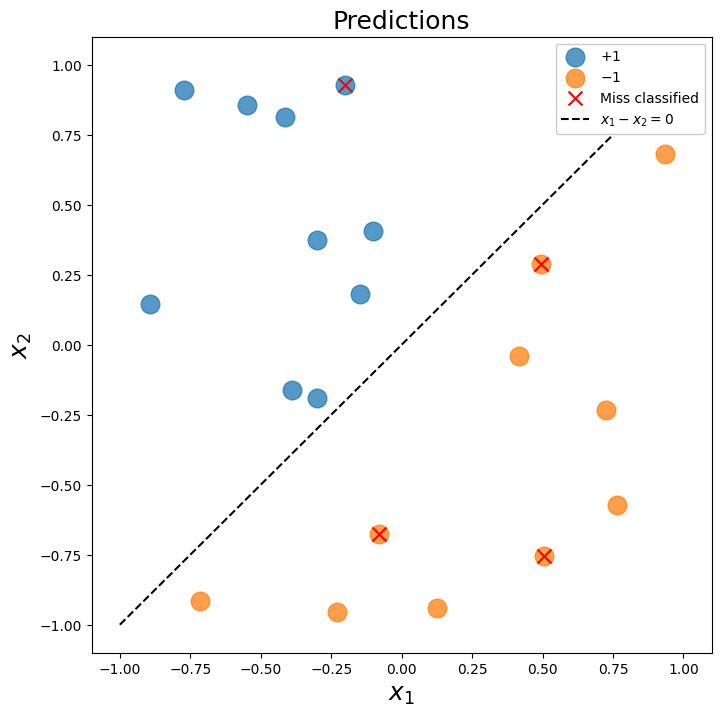

In [13]:
y_predicted = sampler_classifier.predict(X).ravel()
miss_classifed = (y_predicted != labels01)
fig3, ax3 = plt.subplots(1, 1, figsize = (8, 8))
ax3.scatter(xp[:, 0], xp[:, 1], label = "$+1$", s = 180, alpha = 0.75, zorder = 0)
ax3.scatter(xm[:, 0], xm[:, 1], label = "$-1$", s = 180, alpha = 0.75, zorder = 0)
ax3.scatter(X[miss_classifed][:, 0], X[miss_classifed][:, 1], label = "Miss classified", c  = "red", marker = "x", alpha = 1, zorder = 20, s = 100)
ax3.plot([-1, 1], [-1, 1], ls = "--", c = "black", label = "$x_1 - x_2 = 0$")
ax3.set_xlabel("$x_1$", size = 18)
ax3.set_ylabel("$x_2$", size = 18)
ax3.set_title("Predictions", size = 18)
grid_L = 50
#xx = np.outer(np.ones(grid_L), np.linspace(-1, 1, grid_L))
#yy = np.outer(np.linspace(-1, 1, grid_L), np.ones(grid_L))
#zz = sampler_classifier.predict(np.vstack([xx.ravel(), yy.ravel()]).T).ravel().reshape(grid_L, grid_L)
#ax3.pcolormesh(xx, yy, zz, cmap = "gray" ,alpha = 0.2, zorder = -10)
ax3.legend(loc = "upper right", framealpha = 1)

## Variational Quantum Classifier

In [15]:
# construct feature map, ansatz
feature_map = ZZFeatureMap(2, reps = 1)
ansatz = RealAmplitudes(2, reps=1)

# construct variational quantum classifier
vqc = VQC(feature_map=feature_map, ansatz=ansatz, loss="cross_entropy",
          optimizer=COBYLA(maxiter=30), callback=callback_graph)

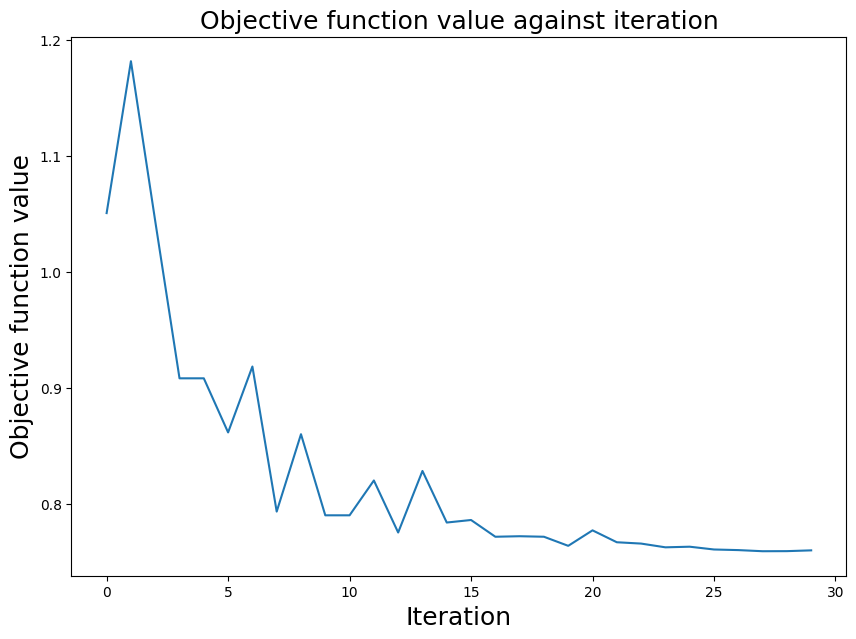

In [16]:
#training
objective_func_vals = []
vqc.fit(X, labels_one_hot)

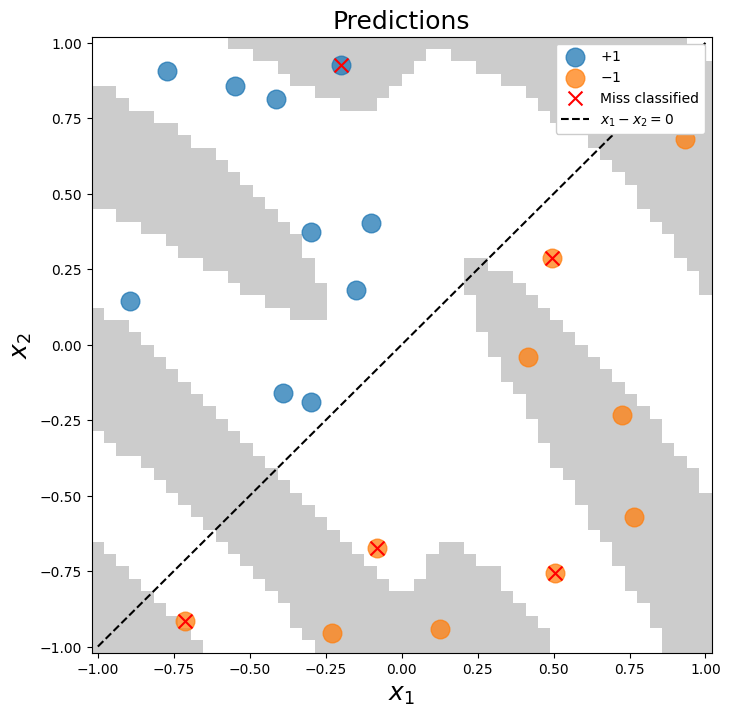

In [18]:
y_predicted = vqc.predict(X)
miss_classifed = (y_predicted[:, 0] != labels01)
fig4, ax4 = plt.subplots(1, 1, figsize = (8, 8))
ax4.scatter(xp[:, 0], xp[:, 1], label = "$+1$", s = 180, alpha = 0.75, zorder = 0)
ax4.scatter(xm[:, 0], xm[:, 1], label = "$-1$", s = 180, alpha = 0.75, zorder = 0)
ax4.scatter(X[miss_classifed][:, 0], X[miss_classifed][:, 1], label = "Miss classified", c  = "red", marker = "x", alpha = 1, zorder = 20, s = 100)
ax4.plot([-1, 1], [-1, 1], ls = "--", c = "black", label = "$x_1 - x_2 = 0$")
ax4.set_xlabel("$x_1$", size = 18)
ax4.set_ylabel("$x_2$", size = 18)
ax4.set_title("Predictions", size = 18)
grid_L = 50
xx = np.outer(np.ones(grid_L), np.linspace(-1, 1, grid_L))
yy = np.outer(np.linspace(-1, 1, grid_L), np.ones(grid_L))
zz = vqc.predict(np.vstack([xx.ravel(), yy.ravel()]).T)[:, 0].reshape(grid_L, grid_L)
ax4.pcolormesh(xx, yy, zz, cmap = "gray" ,alpha = 0.2, zorder = -10)
ax4.legend(loc = "upper right", framealpha = 1)